In [1]:
# =========================================================
# Advanced HMM Upgrade (Without IRT and Info-Gain Selection)
# Implements:
# Streak Momentum
# Time-Decay Forgetting
# EM-Based Transition Estimation (Simplified Baum-Welch)
# Hierarchical Skill Graph
# Live Model Metrics
# =========================================================

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# ---------------------------------------------------------
# Core Setup
# ---------------------------------------------------------
states = ["learning", "practicing", "mastered"]
n_states = 3

pi = np.array([0.2, 0.6, 0.2])

A = np.array([
    [0.75, 0.23, 0.02],
    [0.07, 0.88, 0.05],
    [0.00, 0.10, 0.90]
])

base_mastery = {
    "learning": 0.35,
    "practicing": 0.55,
    "mastered": 0.90
}

difficulty_multiplier = {
    "easy": 1.0,
    "moderate": 0.9,
    "hard": 0.75
}


Brier Score: 0.2176
Log Loss: 0.625
Average Belief Entropy: 0.8307


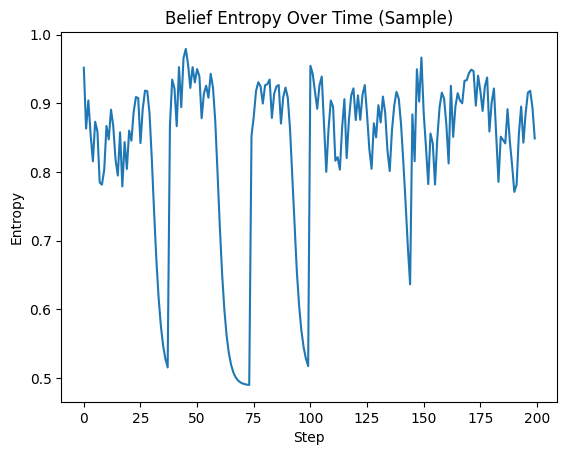


EM-Estimated Transition Matrix:
 [[0.74612403 0.24127907 0.0125969 ]
 [0.07381099 0.86905497 0.05713403]
 [0.         0.10289017 0.89710983]]


In [3]:
# ---------------------------------------------------------
# Streak Momentum
# ---------------------------------------------------------
def apply_streak_momentum(A, streak):
    A_mod = A.copy()
    if streak >= 3:
        A_mod[1,2] += 0.03  # boost mastery transition
        A_mod[1,1] -= 0.03
    if streak <= -3:
        A_mod[2,1] += 0.03  # boost regression
        A_mod[2,2] -= 0.03
    return A_mod

# ---------------------------------------------------------
# Time-Decay Forgetting
# ---------------------------------------------------------
def apply_time_decay(belief, days_absent, decay_rate=0.05):
    lambda_ = np.exp(-decay_rate * days_absent)
    return lambda_ * belief + (1 - lambda_) * pi

# ---------------------------------------------------------
# Belief Update
# ---------------------------------------------------------
def update_belief(belief, observation, difficulty, slip, guess, persistence, streak):
    A_mod = apply_streak_momentum(A, streak)
    new_belief = np.zeros_like(belief)
    
    for i, state in enumerate(states):
        mastery = base_mastery[state]
        adj_slip = slip * (1 - 0.5 * persistence)
        p_correct = mastery * (1 - adj_slip) + (1 - mastery) * guess
        p_correct *= difficulty_multiplier[difficulty]
        emission = p_correct if observation == 1 else (1 - p_correct)
        transition_sum = np.sum(belief * A_mod[:, i])
        new_belief[i] = emission * transition_sum
    
    new_belief /= np.sum(new_belief)
    return new_belief

# ---------------------------------------------------------
# Simplified EM Transition Estimation
# ---------------------------------------------------------
def estimate_transition_matrix(sequences):
    counts = np.zeros((n_states, n_states))
    for seq in sequences:
        for t in range(len(seq)-1):
            counts[seq[t], seq[t+1]] += 1
    row_sums = counts.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    return counts / row_sums

# Simulate hidden state sequences for EM demo
hidden_sequences = []
for _ in range(200):
    seq = [np.random.choice(n_states, p=pi)]
    for _ in range(30):
        seq.append(np.random.choice(n_states, p=A[seq[-1]]))
    hidden_sequences.append(seq)

A_em = estimate_transition_matrix(hidden_sequences)

# ---------------------------------------------------------
# Hierarchical Skill Graph
# ---------------------------------------------------------
skills = {
    "spatial_parent": np.array([0.3, 0.5, 0.2]),
    "rotation": np.array([0.2, 0.6, 0.2]),
    "visualization": np.array([0.2, 0.6, 0.2])
}

def propagate_parent_influence(skills, weight=0.1):
    parent = skills["spatial_parent"]
    for child in ["rotation", "visualization"]:
        skills[child] = (1-weight)*skills[child] + weight*parent
    return skills

skills = propagate_parent_influence(skills)

# ---------------------------------------------------------
# Live Model Metrics
# ---------------------------------------------------------
n_students = 500
n_steps = 25

pred_probs = []
true_outcomes = []
entropy_vals = []

for _ in range(n_students):
    belief = pi.copy()
    slip = np.random.uniform(0.05, 0.12)
    guess = np.random.uniform(0.10, 0.20)
    persistence = np.random.uniform(0.3, 0.9)
    streak = 0
    
    for _ in range(n_steps):
        difficulty = np.random.choice(["easy", "moderate", "hard"])
        mastery_probs = np.array([base_mastery[s] for s in states])
        p_correct_pred = np.sum(belief * mastery_probs)
        outcome = np.random.binomial(1, p_correct_pred)
        
        pred_probs.append(p_correct_pred)
        true_outcomes.append(outcome)
        
        streak = streak + 1 if outcome == 1 else streak - 1
        
        belief = update_belief(belief, outcome, difficulty, slip, guess, persistence, streak)
        
        entropy = -np.sum(belief * np.log(belief + 1e-9))
        entropy_vals.append(entropy)

pred_probs = np.array(pred_probs)
true_outcomes = np.array(true_outcomes)

brier = np.mean((pred_probs - true_outcomes)**2)
log_loss = -np.mean(true_outcomes*np.log(pred_probs+1e-9) + (1-true_outcomes)*np.log(1-pred_probs+1e-9))
avg_entropy = np.mean(entropy_vals)

print("Brier Score:", round(brier,4))
print("Log Loss:", round(log_loss,4))
print("Average Belief Entropy:", round(avg_entropy,4))

# Plot Entropy Trend
plt.figure()
plt.plot(entropy_vals[:200])
plt.title("Belief Entropy Over Time (Sample)")
plt.xlabel("Step")
plt.ylabel("Entropy")
plt.show()

print("\nEM-Estimated Transition Matrix:\n", A_em)
